In [6]:
# ========= run_cc_cccv.py =========
import os, copy, pickle
import numpy as np
import pandas as pd

# ----------------- 配置 & 输出目录 -----------------
OUTDIR = "figures_out"
os.makedirs(OUTDIR, exist_ok=True)
PKL_PATH = os.path.join(OUTDIR, "cc_cccv_results.pkl")
CSV_PATH = os.path.join(OUTDIR, "cc_cccv_summary.csv")

# ----------------- 电芯参数库 -----------------
cell_library = {
    'NMC': dict(
        H=24*60, C_max=1.0, tilde_Q_1=3.0, tilde_V=3.6, N=0.5,
        cons_z=0.60, cons_alpha=29.0, cons_beta=74.0, cons_delta=1/60,
        cons_eta=155.0, cons_E_a=35000, cons_R_g=8.314, cons_T=273.15+25,
        cons_omega=np.exp(-35000/(8.314*(273.15+25)))
    ),
    'LFP': dict(
        H=24*60, C_max=1.0, tilde_Q_1=3.2, tilde_V=3.2, N=0.5,
        cons_z=0.55, cons_alpha=25.0, cons_beta=70.0, cons_delta=1/60,
        cons_eta=120.0, cons_E_a=30000, cons_R_g=8.314, cons_T=273.15+25,
        cons_omega=np.exp(-30000/(8.314*(273.15+25)))
    )
}

def choose_cell(chemistry: str):
    if chemistry not in cell_library:
        raise ValueError(f'未知电芯类型: {chemistry}')
    return copy.deepcopy(cell_library[chemistry])

# ----------------- 老化模型 -----------------
def aging(tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx=False):
    mu_t = (cell_constants['cons_beta'] * cell_constants['cons_omega'] *
            cell_constants['cons_z'] * np.power(ah_t, cell_constants['cons_z'] - 1))
    nu_t = 0 if tilde_Q_t == 0 else cell_constants['cons_alpha'] / (cell_constants['cons_beta'] * tilde_Q_t)
    lambda_t = 0 if tilde_Q_t == 0 else cell_constants['cons_eta'] / (cell_constants['cons_R_g'] * cell_constants['cons_T'] * tilde_Q_t)
    if not approx:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * tilde_q_t)) * np.exp(lambda_t * abs(tilde_b_t))
    else:
        rho_t = mu_t * abs(tilde_b_t) * (1 + (nu_t * (tilde_Q_t/2)))
    Sigma_rho_t = Sigma_rho_t + rho_t
    l_t = Sigma_rho_t * cell_constants['cons_delta']
    tilde_Q_t = cell_constants['tilde_Q_1'] * (1 - l_t)
    return l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t

# ----------------- CC 模拟器 -----------------
def bang_bang_simulator(cell_constants: dict, approx=False):
    E = int(20 * 365 * cell_constants['H'] + 6 * cell_constants['H'])
    tilde_b = np.zeros((E,))
    tilde_q = np.zeros((E,))
    tilde_Q = np.zeros((E,))
    l = np.zeros((E,))
    ah = np.zeros((E,))
    mu_one_plus_nu_q = np.zeros((E,))
    Sigma_rho = np.zeros((E,))

    cycle_state = 'charge'
    tilde_b_t = 0.0
    tilde_q_t = 0.0
    tilde_q_t_1 = 0.0
    tilde_Q_t = cell_constants['tilde_Q_1']
    Sigma_rho_t = 0.0
    ah_t = 2.5

    for e in range(E):
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break

        tilde_b_t = -cell_constants['C_max'] * tilde_Q_t if cycle_state == 'charge' else cell_constants['C_max'] * tilde_Q_t

        tilde_q_t_1 = tilde_q_t
        tilde_q_t = np.clip(tilde_q_t_1 - tilde_b_t * cell_constants['cons_delta'], 0, tilde_Q_t)
        tilde_b_t = (tilde_q_t - tilde_q_t_1) / cell_constants['cons_delta']

        ah_t = ah_t + (abs(tilde_b_t) * cell_constants['cons_delta'])
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(
            tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx
        )
        mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5 * tilde_Q_t))

        tilde_b[e] = tilde_b_t
        tilde_q[e] = tilde_q_t
        tilde_Q[e] = tilde_Q_t
        l[e] = l_t
        ah[e] = ah_t
        Sigma_rho[e] = Sigma_rho_t
        mu_one_plus_nu_q[e] = mu_one_plus_nu_q_t

        if cycle_state == 'charge' and tilde_q_t >= 0.99 * tilde_Q_t:
            cycle_state = 'discharge'
        elif cycle_state == 'discharge' and tilde_q_t <= 0.01 * tilde_Q_t:
            cycle_state = 'charge'

    E_sim = e
    sl = slice(None, E_sim)
    cell_variables = {
        'tilde_b': tilde_b[sl], 'tilde_q': tilde_q[sl], 'tilde_Q': tilde_Q[sl],
        'l': l[sl], 'ah': ah[sl], 'mu_one_plus_nu_q': mu_one_plus_nu_q[sl], 'Sigma_rho': Sigma_rho[sl]
    }
    lifetime_in_years = E_sim / (365 * cell_constants['H'])
    num_cycles = np.sum(np.diff(np.sign(tilde_b[sl])) != 0) // 2
    ah_at_the_end = ah[sl][-1]
    return cell_variables, E_sim, lifetime_in_years, num_cycles, ah_at_the_end

# ----------------- CCCV 模拟器 -----------------
def cccv_simulator(cell_constants: dict, approx=False,
                   s_cv_start=0.90, I_min_frac=0.05, tau_cv_hours=0.5):
    E = int(20 * 365 * cell_constants['H'] + 6 * cell_constants['H'])
    tilde_b = np.zeros((E,))
    tilde_q = np.zeros((E,))
    tilde_Q = np.zeros((E,))
    l = np.zeros((E,))
    ah = np.zeros((E,))
    mu_one_plus_nu_q = np.zeros((E,))
    Sigma_rho = np.zeros((E,))

    phase = 'charge_cc'
    t_cv = 0.0
    I0_cv = 0.0
    delta_h = cell_constants['cons_delta']

    tilde_b_t = 0.0
    tilde_q_t = 0.0
    tilde_q_t_1 = 0.0
    tilde_Q_t = cell_constants['tilde_Q_1']
    Sigma_rho_t = 0.0
    ah_t = 2.5

    for e in range(E):
        if tilde_Q_t <= 0.90 * cell_constants['tilde_Q_1']:
            break

        if phase == 'charge_cc':
            tilde_b_t = -cell_constants['C_max'] * tilde_Q_t
            if tilde_q_t >= s_cv_start * tilde_Q_t:
                phase = 'charge_cv'
                t_cv = 0.0
                I0_cv = cell_constants['C_max'] * tilde_Q_t
        elif phase == 'charge_cv':
            I_min = I0_cv * I_min_frac
            I_now = max(I_min, I0_cv * np.exp(-t_cv / tau_cv_hours))
            tilde_b_t = -I_now
        else:
            tilde_b_t =  cell_constants['C_max'] * tilde_Q_t

        tilde_q_t_1 = tilde_q_t
        tilde_q_t = np.clip(tilde_q_t_1 - tilde_b_t * delta_h, 0, tilde_Q_t)
        tilde_b_t = (tilde_q_t - tilde_q_t_1) / delta_h

        if phase in ('charge_cc', 'charge_cv'):
            if tilde_q_t >= 0.99 * tilde_Q_t:
                phase = 'discharge_cc'
                t_cv = 0.0
            elif phase == 'charge_cv':
                t_cv += delta_h
        elif phase == 'discharge_cc':
            if tilde_q_t <= 0.01 * tilde_Q_t:
                phase = 'charge_cc'
                t_cv = 0.0

        ah_t = ah_t + (abs(tilde_b_t) * delta_h)
        l_t, tilde_Q_t, mu_t, nu_t, Sigma_rho_t = aging(
            tilde_b_t, tilde_q_t, tilde_Q_t, ah_t, Sigma_rho_t, cell_constants, approx
        )
        mu_one_plus_nu_q_t = mu_t * (1 + (nu_t * 0.5 * tilde_Q_t))

        tilde_b[e] = tilde_b_t
        tilde_q[e] = tilde_q_t
        tilde_Q[e] = tilde_Q_t
        l[e] = l_t
        ah[e] = ah_t
        Sigma_rho[e] = Sigma_rho_t
        mu_one_plus_nu_q[e] = mu_one_plus_nu_q_t

    E_sim = e
    sl = slice(None, E_sim)
    cell_variables = {
        'tilde_b': tilde_b[sl], 'tilde_q': tilde_q[sl], 'tilde_Q': tilde_Q[sl],
        'l': l[sl], 'ah': ah[sl], 'mu_one_plus_nu_q': mu_one_plus_nu_q[sl], 'Sigma_rho': Sigma_rho[sl]
    }
    lifetime_in_years = E_sim / (365 * cell_constants['H'])
    num_cycles = np.sum(np.diff(np.sign(tilde_b[sl])) != 0) // 2
    ah_at_the_end = ah[sl][-1]
    return cell_variables, E_sim, lifetime_in_years, num_cycles, ah_at_the_end

# ----------------- 主实验：跑并保存 -----------------
def run_and_save():
    chem_list   = list(cell_library.keys())     # ['NMC', 'LFP']
    rate_mults  = [0.03625, 0.0625, 0.125, 0.25, 0.5, 1.0]
    protocols   = ['CC', 'CCCV']

    results = {
        "meta": {"chem_list": chem_list, "rate_mults": rate_mults, "protocols": protocols},
        "chem": {}
    }
    summary_rows = []

    for chem in chem_list:
        const_base = choose_cell(chem)
        H = const_base['H']

        daily_profiles = {}   # (proto, mult) -> (q, b)
        loss_profiles  = {}   # (proto, mult) -> l

        for mult in rate_mults:
            for proto in protocols:
                const = choose_cell(chem)
                const['C_max'] = const['C_max'] * mult

                if proto == 'CC':
                    cell_vars, E_sim, life, cycles, ah_end = bang_bang_simulator(const, approx=False)
                else:
                    cell_vars, E_sim, life, cycles, ah_end = cccv_simulator(const, approx=False)

                # 存结果（单位换算放到绘图阶段也行；这里先保留“原始单位”）
                q = cell_vars['tilde_q'] * const['N'] * const['tilde_V']  # ~ MWh
                b = cell_vars['tilde_b'] * const['N'] * const['tilde_V']  # ~ MW
                daily_profiles[(proto, mult)] = (q, b)
                loss_profiles[(proto, mult)]  = cell_vars['l']

                summary_rows.append(dict(
                    Protocol=proto, Chem=chem, C_rate_mult=mult,
                    Lifetime_yr=life, Cycles=cycles, Ah_Throughput=int(ah_end)
                ))

        results["chem"][chem] = dict(H=H, daily_profiles=daily_profiles, loss_profiles=loss_profiles)

    # 保存
    with open(PKL_PATH, "wb") as f:
        pickle.dump(results, f)

    summary_df = pd.DataFrame(summary_rows)
    summary_df.to_csv(CSV_PATH, index=False)

    print(f"[saved] {PKL_PATH}")
    print(f"[saved] {CSV_PATH}")
    print("\n===== SUMMARY (CC vs CCCV) =====")
    print(summary_df.to_string(index=False))

if __name__ == "__main__":
    run_and_save()


[saved] figures_out\cc_cccv_results.pkl
[saved] figures_out\cc_cccv_summary.csv

===== SUMMARY (CC vs CCCV) =====
Protocol Chem  C_rate_mult  Lifetime_yr  Cycles  Ah_Throughput
      CC  NMC      0.03625    20.016436    3240          18786
    CCCV  NMC      0.03625    20.016436    1886          10981
      CC  NMC      0.06250    20.016436    5585          32198
    CCCV  NMC      0.06250    20.016436    3476          20129
      CC  NMC      0.12500    20.016436   11158          63690
    CCCV  NMC      0.12500    20.016436    8288          47517
      CC  NMC      0.25000    20.016436   22270         125235
    CCCV  NMC      0.25000    20.016436   21648         121739
      CC  NMC      0.50000    15.721718   34832         193543
    CCCV  NMC      0.50000    15.874979   34985         193655
      CC  NMC      1.00000     7.462137   32684         183726
    CCCV  NMC      1.00000     7.495917   32969         183786
      CC  LFP      0.03625    19.079644    3089          18132
    

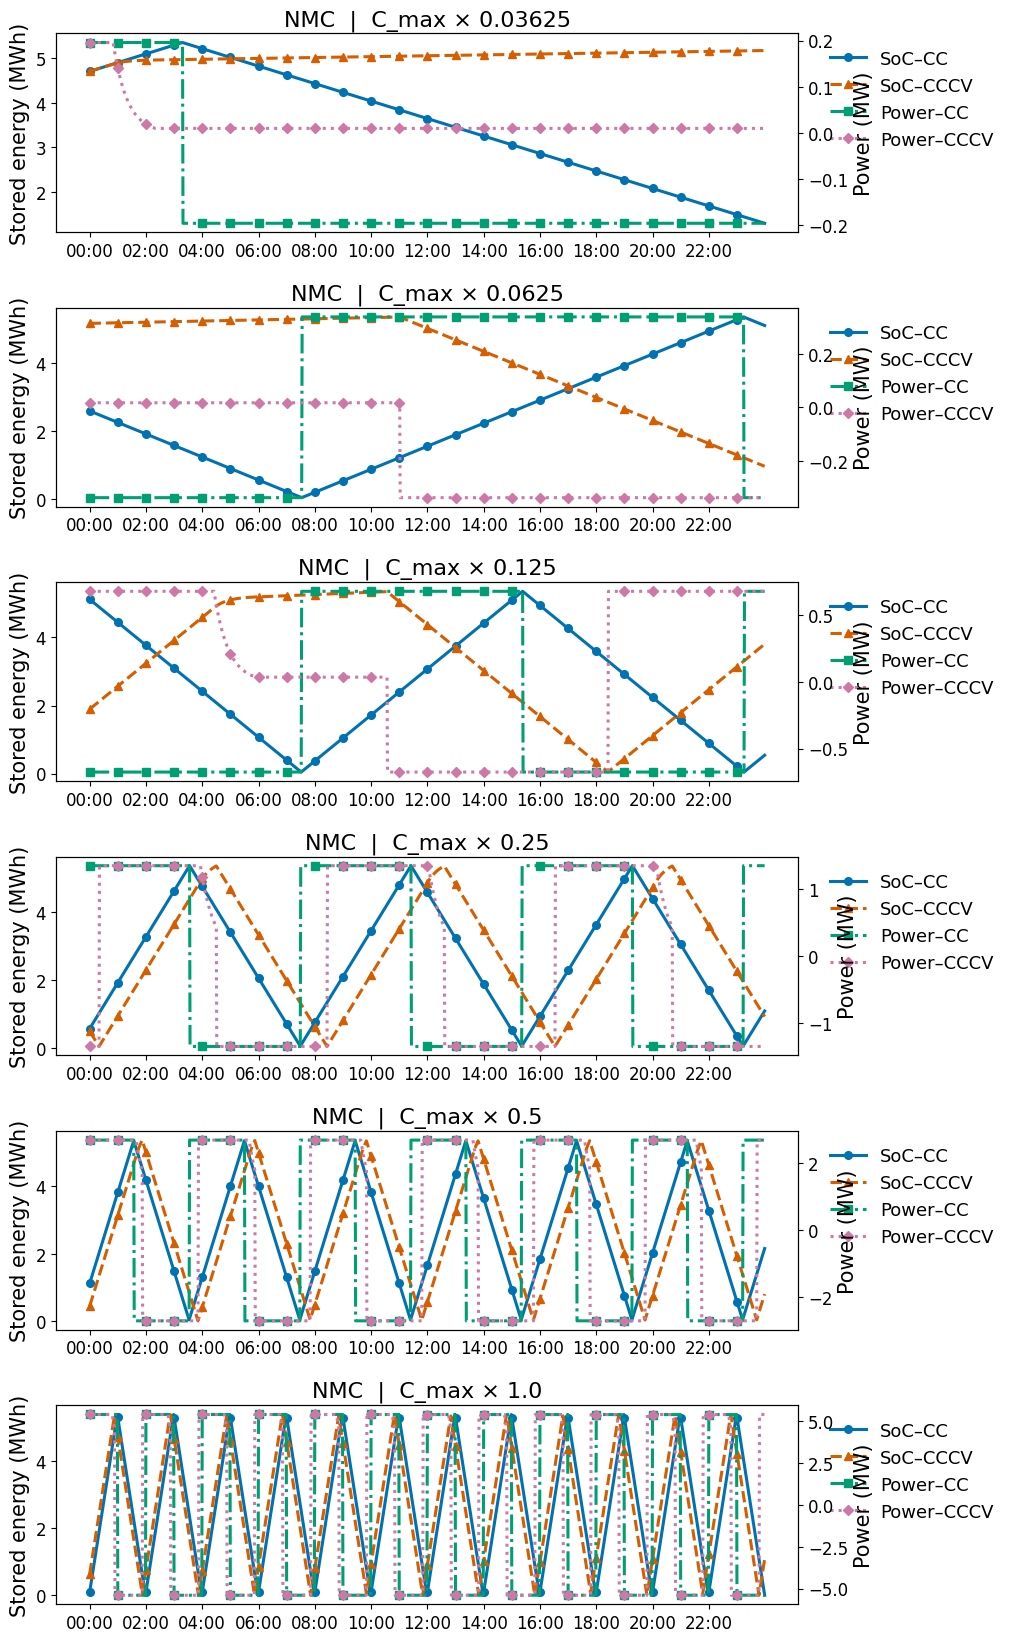

C:\Users\msz\AppData\Local\Temp\ipykernel_27052\2619718864.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


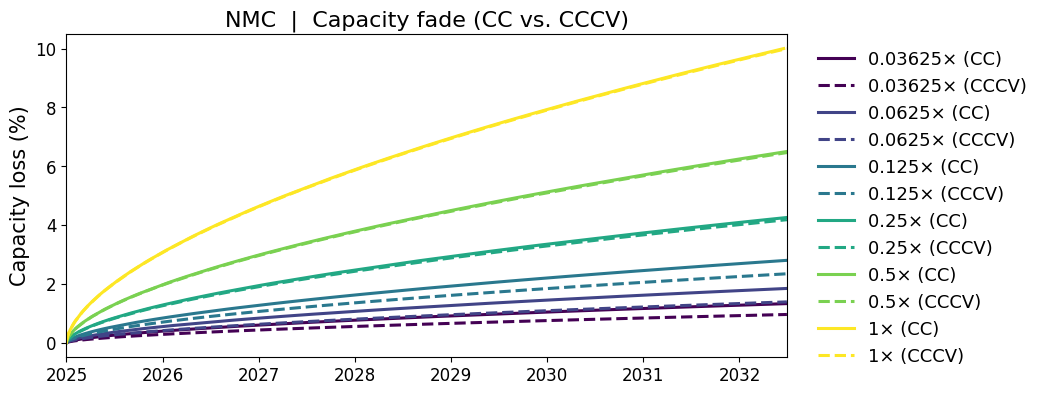

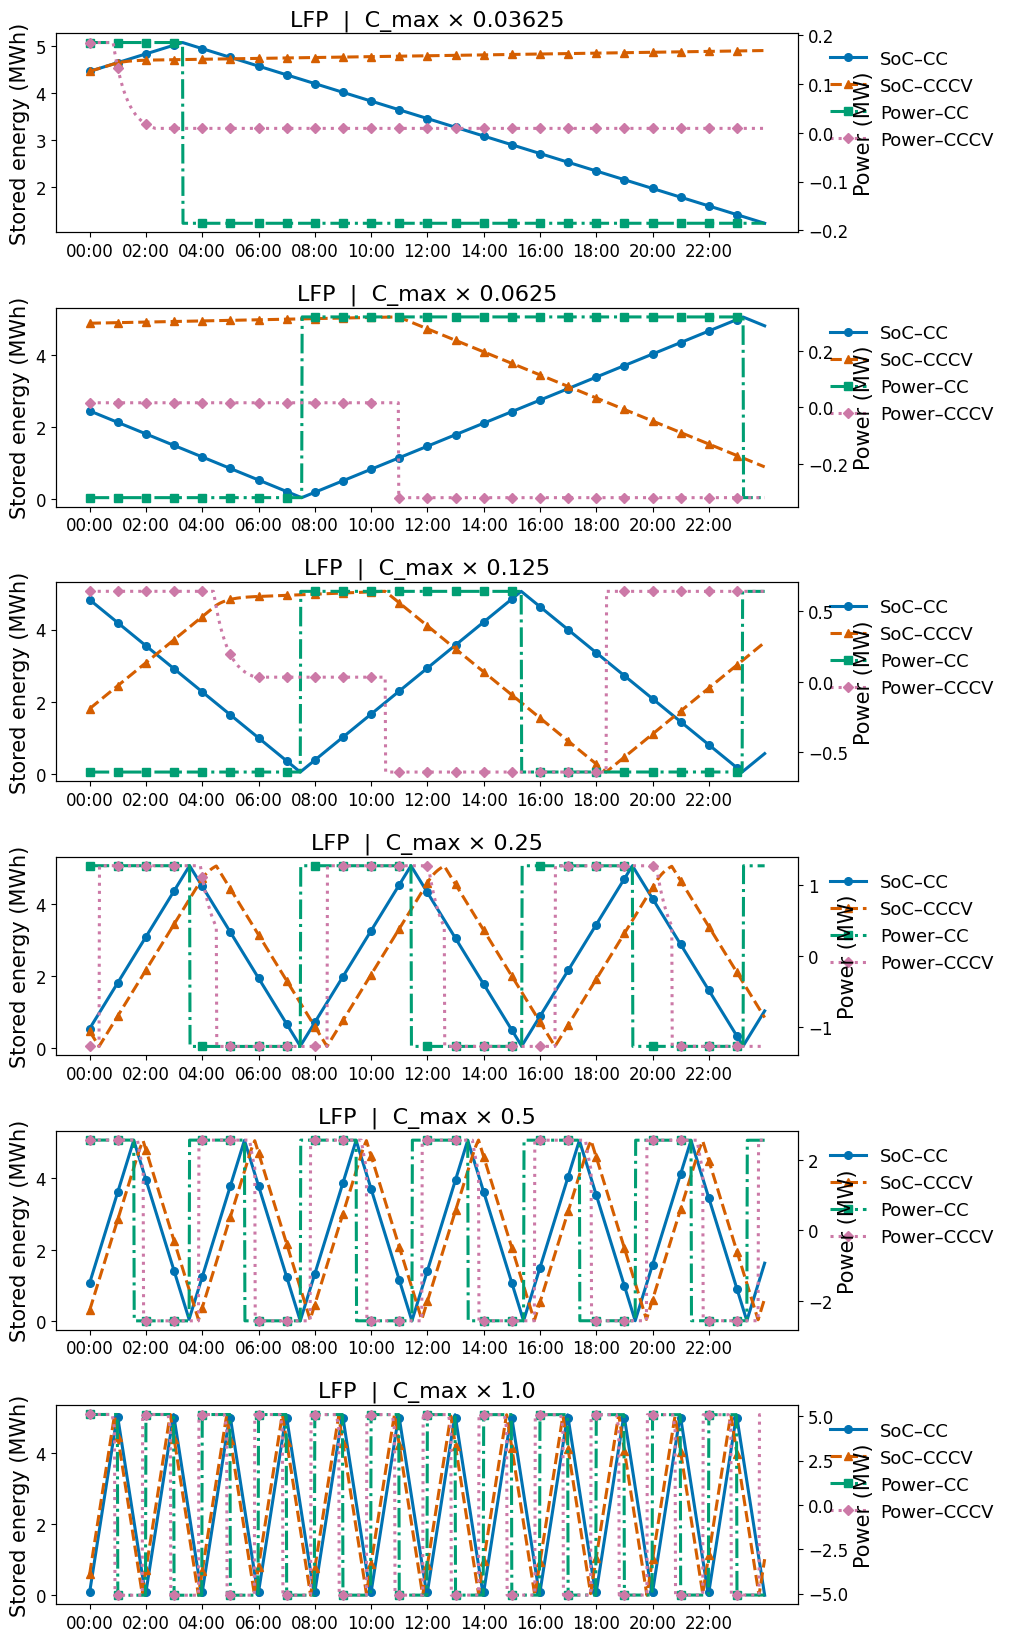

C:\Users\msz\AppData\Local\Temp\ipykernel_27052\2619718864.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


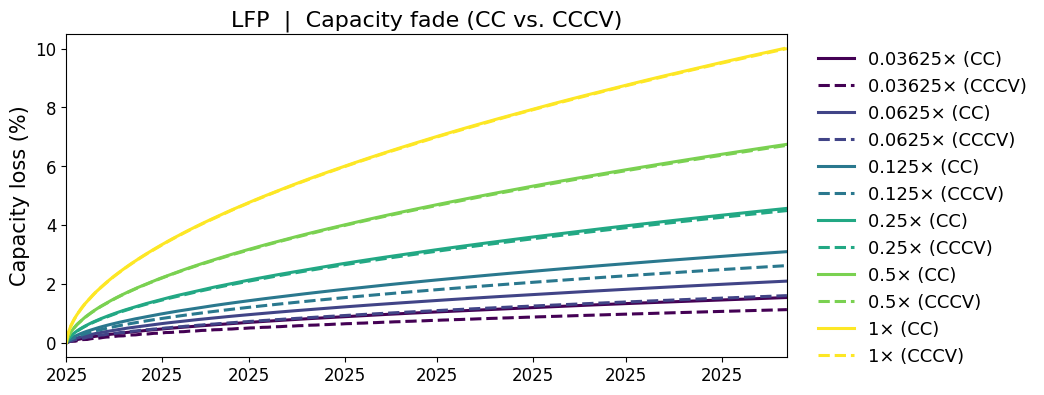

,Protocol,Chem,C_rate_mult,Lifetime_yr,Cycles,Ah_Throughput
0,CC,NMC,0.03625,20.016436,3240,18786
1,CCCV,NMC,0.03625,20.016436,1886,10981
2,CC,NMC,0.06250,20.016436,5585,32198
3,CCCV,NMC,0.06250,20.016436,3476,20129
4,CC,NMC,0.12500,20.016436,11158,63690
5,CCCV,NMC,0.12500,20.016436,8288,47517
6,CC,NMC,0.25000,20.016436,22270,125235
7,CCCV,NMC,0.25000,20.016436,21648,121739
8,CC,NMC,0.50000,15.721718,34832,193543
9,CCCV,NMC,0.50000,15.874979,34985,193655


In [7]:
# ====== plot_cc_cccv (Notebook plotting cell) ======
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.dates import DateFormatter
from collections import OrderedDict
from IPython.display import display

# ----------------- 路径 -----------------
OUTDIR   = "figures_out"
PKL_PATH = os.path.join(OUTDIR, "cc_cccv_results.pkl")
CSV_PATH = os.path.join(OUTDIR, "cc_cccv_summary.csv")
os.makedirs(OUTDIR, exist_ok=True)

# ----------------- 样式与工具 -----------------
plt.rcParams.update({
    'font.size': 14, 'axes.titlesize': 16, 'axes.labelsize': 15,
    'legend.fontsize': 13, 'xtick.labelsize': 12, 'ytick.labelsize': 12,
    'lines.linewidth': 2.2, 'lines.markersize': 5.5, 'savefig.dpi': 300
})

COLORS = {
    'black':   '#000000',
    'blue':    '#0072B2',   # SoC-CC
    'orange':  '#D55E00',   # SoC-CCCV
    'green':   '#009E73',   # Power-CC
    'magenta': '#CC79A7',   # Power-CCCV
    'red':     '#D62728',
}

# 四条线风格（确保完全不同）
STYLE_SOC_CC    = dict(color=COLORS['blue'],   ls='-',  marker='o',  markevery=60)  # 每小时一个点
STYLE_SOC_CCCV  = dict(color=COLORS['orange'], ls='--', marker='^',  markevery=60)
STYLE_PWR_CC    = dict(color=COLORS['green'],  ls='-.', marker='s',  markevery=60)
STYLE_PWR_CCCV  = dict(color=COLORS['magenta'],ls=':',  marker='D',  markevery=60)

def show_and_save(fig, base_no_ext: str):
    """同时保存 PDF/PNG，并在 notebook 内联展示（图例在图外时建议用 bbox_inches='tight'）。"""
    pdf = os.path.join(OUTDIR, f"{base_no_ext}.pdf")
    png = os.path.join(OUTDIR, f"{base_no_ext}.png")
    fig.savefig(pdf, bbox_inches='tight')
    fig.savefig(png, dpi=600, bbox_inches='tight')
    display(fig)   # 内联显示
    plt.close(fig) # 释放

# ----------------- 绘图：日曲线（四条线，图例右侧图外） -----------------
def plot_daily_profiles(chem, H, daily_profiles):
    """
    daily_profiles[(proto, mult)] = (q, b)
    q≈MWh, b≈MW；只取 [H:2H] 这一天
    """
    rate_mults  = sorted({m for (_, m) in daily_profiles.keys()})
    times_day   = pd.date_range('2000-01-01 00:00', periods=2*H, freq='1min')
    nrows       = len(rate_mults)
    fig, axes   = plt.subplots(nrows, 1, figsize=(11, 3.4*nrows), sharey=False)
    if nrows == 1:
        axes = [axes]

    # 给右侧图外图例留出空间
    fig.subplots_adjust(right=0.80, hspace=0.38)

    for idx, mult in enumerate(rate_mults):
        ax  = axes[idx]
        axr = ax.twinx()
        tseg = slice(H, 2*H)

        # 取出该倍率的 CC / CCCV
        if ('CC', mult) not in daily_profiles or ('CCCV', mult) not in daily_profiles:
            ax.text(0.02, 0.88, f"缺少 {mult}× 的 CC/CCCV 数据", transform=ax.transAxes, color='red')
            continue
        q_cc, b_cc = daily_profiles[('CC', mult)]
        q_cv, b_cv = daily_profiles[('CCCV', mult)]

        # 左轴：SoC（能量）
        ln1, = ax.plot(times_day[tseg], q_cc[tseg],  label='SoC–CC',   **STYLE_SOC_CC)
        ln2, = ax.plot(times_day[tseg], q_cv[tseg],  label='SoC–CCCV', **STYLE_SOC_CCCV)
        ax.set_ylabel('Stored energy (MWh)')
        ax.set_xticks(pd.date_range(times_day.min(), times_day.max(), freq='2h'))
        ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
        ax.tick_params(axis='x', rotation=0)
        ax.set_title(f'{chem}  |  C_max × {mult}')

        # 右轴：Power（功率）
        ln3, = axr.plot(times_day[tseg], b_cc[tseg], label='Power–CC',   **STYLE_PWR_CC)
        ln4, = axr.plot(times_day[tseg], b_cv[tseg], label='Power–CCCV', **STYLE_PWR_CCCV)
        axr.set_ylabel('Power (MW)')

        # 合并 4 条线做一个图外图例（右侧同一侧）
        handles = [ln1, ln2, ln3, ln4]
        labels  = [h.get_label() for h in handles]
        ax.legend(handles, labels, loc='upper left',
                  bbox_to_anchor=(1.02, 1.0), frameon=False)

    show_and_save(fig, f'daily_profiles_{chem}')

# ----------------- 绘图：容量衰退（图例右侧图外） -----------------
def plot_capacity_fade(chem, loss_profiles):
    """
    loss_profiles[(proto, mult)] = l (0..1)
    """
    rate_mults  = sorted({m for (_, m) in loss_profiles.keys()})
    protocols   = ['CC', 'CCCV']

    # 颜色映射给倍率；线型区分协议
    cmap = get_cmap('viridis')
    mult_colors = {m: cmap(i/(len(rate_mults)-1) if len(rate_mults)>1 else 0.5)
                   for i, m in enumerate(rate_mults)}

    fig, ax = plt.subplots(figsize=(11, 4.2))
    all_handles, all_labels = [], []

    for mult in rate_mults:
        for proto in protocols:
            if (proto, mult) not in loss_profiles:
                continue
            l = loss_profiles[(proto, mult)]
            t = pd.date_range('2025-01-01', periods=len(l), freq='1min')
            ls = '-' if proto == 'CC' else '--'
            (ln,) = ax.plot(t, l*100, color=mult_colors[mult], ls=ls,
                            label=f'{mult:g}× ({proto})')
            all_handles.append(ln); all_labels.append(ln.get_label())

    ax.set_ylabel('Capacity loss (%)')
    ax.set_title(f'{chem}  |  Capacity fade (CC vs. CCCV)')
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    if len(all_handles):
        ax.set_xlim(left=t[0], right=t[-1])

    # 去重保序 + 图外右侧
    by_label = OrderedDict(zip(all_labels, all_handles))
    handles  = list(by_label.values())
    labels   = list(by_label.keys())
    ax.legend(handles, labels, loc='upper left',
              bbox_to_anchor=(1.02, 1.0), frameon=False)
    fig.subplots_adjust(right=0.78)

    show_and_save(fig, f'capacity_fade_{chem}')

# ----------------- 主绘图入口 -----------------
# 读取结果并绘图
if not os.path.exists(PKL_PATH):
    raise FileNotFoundError(f"未找到 {PKL_PATH} ，请先在上一段代码中运行实验并保存。")

with open(PKL_PATH, "rb") as f:
    results = pickle.load(f)

for chem in results["meta"]["chem_list"]:
    H = results["chem"][chem]["H"]
    daily_profiles = results["chem"][chem]["daily_profiles"]
    loss_profiles  = results["chem"][chem]["loss_profiles"]
    plot_daily_profiles(chem, H, daily_profiles)
    plot_capacity_fade(chem, loss_profiles)

# 可选：展示总结表
if os.path.exists(CSV_PATH):
    df = pd.read_csv(CSV_PATH)
    display(df)
